<a href="https://colab.research.google.com/github/gabrielebilliciani/knowledge-distillation/blob/main/notebooks/regression/Notebook1_KD-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation for Regression

 > **Note**: This notebook is part of an introductory project on Knowledge Distillation. It serves as a practical companion to the main presentation slides. The complete project is available on GitHub at: https://github.com/gabrielebilliciani/knowledge-distillation

This notebook provides a practical demonstration of **Knowledge Distillation (KD)** applied to a regression task. The core principle of KD is to transfer "knowledge" from a large, complex, and high-performing **teacher** model to a smaller, more efficient **student** model. The goal is to enable the student to achieve performance that surpasses what it could learn on its own, thereby creating a model that is both accurate and computationally inexpensive.

### Teacher & Student Architecture Philosophy

We will design our models with distinct roles in mind:
*   **Teacher Model:** A deep neural network (6-8 fully-connected layers) with a high capacity to learn complex mappings from the data. It will use advanced activation functions like **Leaky Rectified Linear Unit (LeakyReLU)** or **Exponential Linear Unit (ELU)** to capture nuanced patterns and prevent issues like dying neurons.
*   **Student Model:** A much shallower network (2-3 fully-connected layers) using the standard **Rectified Linear Unit (ReLU)** activation. This model is designed for simplicity, faster inference, and a lower memory footprint, making it suitable for deployment in resource-constrained environments.

### Activation Functions

The choice of activation function influences a network's ability to model non-linear relationships.

*   **ReLU (Rectified Linear Unit):** The standard and most common activation function. It is simple and computationally efficient.
    $$
    f(x) = \max(0, x)
    $$
*   **LeakyReLU (Leaky Rectified Linear Unit):** An improvement over ReLU that allows a small, non-zero gradient when the unit is not active, preventing the "dying ReLU" problem.
  $$ f(x) = \begin{cases} x & \text{if } x \ge 0 \\ \alpha x & \text{if } x < 0 \end{cases} \quad (\text{where } \alpha \text{ is a small constant, e.g. 0.01})
  $$
*   **ELU (Exponential Linear Unit):** Another alternative to ReLU that can help networks learn faster and more accurately by pushing mean activations closer to zero.
  $$
  f(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha (e^x - 1) & \text{if } x \le 0 \end{cases}
  $$

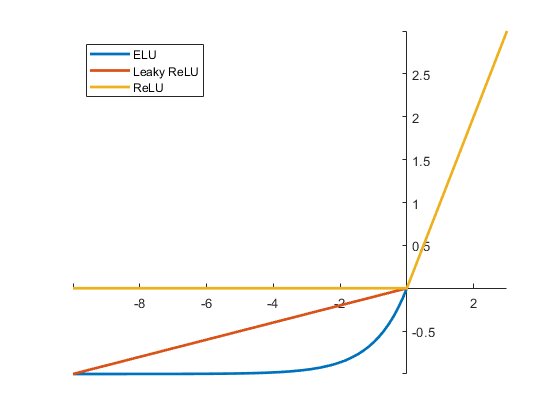

### Distillation Loss Function

To transfer knowledge, the student will be trained to optimise a composite loss function that combines signals from the ground truth data and the teacher's output predictions

The combined loss function, $L$, is a weighted sum of two components:
$$
L = \lambda_1 \|y - y^{(s)}\|^2 + \lambda_2 \|y^{(t)} - y^{(s)}\|^2
$$

Where:
*   **Term 1 (Hard Loss):** The standard regression loss (Mean Squared Error) between the **ground truth target** ($y$) and the **student's prediction** ($y^{(s)}$). This ensures the student learns the primary task. $\lambda_1$ controls its weight.

*   **Term 2 (L_HP - High Precision Distillation):** The L2 distance between the **teacher's prediction** ($y^{(t)}$) and the **student's prediction** ($y^{(s)}$). This is the classic distillation signal, where the student mimics the teacher's output. These "soft targets" from the teacher provide richer information than the hard ground truth labels alone.

### Notebook Goal

In this experiment, we will:
1.  Define and pre-train a powerful teacher model on a dataset.
2.  Train a simple student model from scratch as a baseline.
3.  Train a second student using Hard Loss and $L_{HP}$ distillation (Terms 1 & 2).
4.  Compare the performance of all models on a held-out test set to evaluate the effectiveness of each distillation technique.

# 1. Setup, Configuration and Data Preparation

## Imports and Configuration

First, we import the necessary libraries and set up the main configuration parameters for the experiment. This includes defining the device (GPU or CPU), training hyperparameters like learning rates and batch sizes, and the parameters for generating our synthetic data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Configuration ---

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data generation parameters
N_SAMPLES = 2000
X_MIN, X_MAX = -4, 4
NOISE_LEVEL = 0.1

# Training hyperparameters
BATCH_SIZE = 128
EPOCHS_TEACHER = 700
EPOCHS_STUDENT = 600
LR_TEACHER = 1e-4
LR_STUDENT = 1e-3

# --- CHANGE: Re-balanced distillation loss weights for new strategies ---
# These are dictionaries that will be passed to the training function

# Weights for the student trained only on teacher's predictions (L_HP)
HP_ONLY_WEIGHTS = {'hard': 0.3, 'hp': 0.7}

# Weights for the student trained on predictions and intermediate features (L_HP + L_FEAT)
HP_FEAT_WEIGHTS = {'hard': 0.3, 'hp': 0.4, 'feat': 0.3}


# Number of runs for statistical analysis
N_RUNS = 5

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Using device: cuda


## 1.1 Data Generation and Preprocessing

For this experiment, we will create a **synthetic dataset** to provide a challenging learning environment for our models. The key advantage of a synthetic dataset is that we can precisely control the true underlying function and the level of noise, allowing for a clear evaluation of model performance.

**Data Generation:** We generate `X` features and a target `y` based on a function that is deliberately complex and hard to approximate. It combines several mathematical properties to test a model's flexibility:
*   **Non-linear and periodic terms** (sine, cosine)
*   **Feature interactions** (e.g. `feature1 * feature2`)
*   **A sharp discontinuity** (a step-like change)
*   **Irrelevant "noise" features** that the model must learn to ignore.

Gaussian noise is added to the final output to simulate real-world measurement error.

**Feature Scaling:** The input features are standardised using `StandardScaler` to have a mean of 0 and a standard variance of 1. This is a crucial preprocessing step for neural networks, as it stabilises training and helps the model converge more efficiently.

In [ ]:
N_FEATURES = 10

def generate_highly_complex_data(n_samples, n_features, noise_level):
    """
    Generates data from a complex, non-linear function of multiple features.
    """
    np.random.seed(42)
    X = np.random.uniform(-2, 2, (n_samples, n_features))

    # A complex function involving feature interactions
    # Some features are more important than others
    y_true = (np.sin(X[:, 0] * X[:, 1]) +            # Interaction term
              0.5 * np.cos(X[:, 2] * np.pi) +        # Periodic term
              np.tanh(X[:, 3]) +                     # Non-linear saturation
              0.2 * X[:, 4]**2 -                     # Quadratic term
              1.5 * np.exp(-X[:, 0]**2) +            # Gaussian term
              0.1 * (X[:, 5] > 0).astype(float))   # Discontinuity

    # Add some noise
    y_noisy = y_true + np.random.normal(0, noise_level, y_true.shape)

    # Ensure y has the shape (n_samples, 1)
    return X.astype(np.float32), y_noisy.reshape(-1, 1).astype(np.float32), y_true.reshape(-1, 1).astype(np.float32)

# 1. Generate Data
X, y, y_true_func = generate_highly_complex_data(N_SAMPLES, N_FEATURES, NOISE_LEVEL)

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Convert to PyTorch tensors and move to device
X_train_tensor = torch.from_numpy(X_train_scaled).to(device)
y_train_tensor = torch.from_numpy(y_train).to(device)
X_test_tensor = torch.from_numpy(X_test_scaled).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

# 5. Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data shape: X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")

# Visualization is not meaningful for 10D data, so we'll skip it.

Data shape: X_train: torch.Size([1600, 10]), y_train: torch.Size([1600, 1])


# 2. A Standard Distillation Attempt

In our first experiment, we will test the foundational hypothesis of knowledge distillation. We will create:
1.  A **Teacher Model**: A deep network using `LeakyReLU` activations. It's powerful but does not use extra regularisation like Dropout. We'll simply call it `TeacherNet`.
2.  A **Student Model**: A smaller, less complex network that uses only standard `ReLU` activations, making it suitable for analysis with tools like ReLUplex.

We will compare three models:
- The Teacher model's performance.
- The Student model trained from scratch (our baseline).
- The Student model distilled from the Teacher.

Our hypothesis is that on this complex task, the distilled student should be able to outperform the student trained from scratch.

In [ ]:
# --- Models and Training Functions for Part 1 ---

# The first teacher: Deeper, with LeakyReLU but no Dropout.
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(N_FEATURES, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.layers(x)

# The student model
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(N_FEATURES, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

# Loss function
criterion = nn.MSELoss()

# --- Helper Functions with TQDM ---

def train_model(model, loader, optimizer, epochs, pbar):
    """Standard training loop with an outer tqdm progress bar."""
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        pbar.update(1) 
    return model

def train_student_distilled_fixed(student_model, teacher_model, loader, optimizer, epochs, pbar):
    """Distillation training with FIXED weights and an outer tqdm progress bar."""
    student_model.train()
    teacher_model.eval()
    weights = {'hard': 0.3, 'hp': 0.7}
    for epoch in range(epochs):
        for X_batch, y_batch_true in loader:
            optimizer.zero_grad()
            y_pred_student = student_model(X_batch)
            with torch.no_grad():
                y_pred_teacher = teacher_model(X_batch)
            loss_hard = criterion(y_pred_student, y_batch_true)
            loss_soft_hp = criterion(y_pred_student, y_pred_teacher)
            combined_loss = weights['hard'] * loss_hard + weights['hp'] * loss_soft_hp
            combined_loss.backward()
            optimizer.step()
        pbar.update(1) 
    return student_model

def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()
    mse = mean_squared_error(y_tensor.cpu().numpy(), y_pred)
    r2 = r2_score(y_tensor.cpu().numpy(), y_pred)
    return y_pred, mse, r2

In [ ]:
# --- Part 1: Experiment Execution ---

EPOCHS_STUDENT = 600

initial_student_states = []
part1_results = {
    "Teacher": {'mse': [], 'r2': []},
    "Student (Scratch)": {'mse': [], 'r2': []},
    "Student (Distilled)": {'mse': [], 'r2': []}
}

# --- Main progress bar for the runs ---
with tqdm(total=N_RUNS, desc="Overall Progress") as run_pbar:
    for i in range(N_RUNS):
        run_pbar.set_description(f"Run {i+1}/{N_RUNS}")
        torch.manual_seed(i); np.random.seed(i)

        template_student = StudentNet().to(device)
        initial_student_states.append(template_student.state_dict())

        # --- Train Teacher ---
        run_pbar.set_postfix_str("Training Teacher...")
        teacher = TeacherNet().to(device)
        optimizer_teacher = optim.Adam(teacher.parameters(), lr=LR_TEACHER, weight_decay=1e-5)
        with tqdm(total=EPOCHS_TEACHER, desc="Teacher Training", leave=False) as epoch_pbar:
            teacher = train_model(teacher, train_loader, optimizer_teacher, EPOCHS_TEACHER, epoch_pbar)

        # --- Train Student (Scratch) ---
        run_pbar.set_postfix_str("Training Student (Scratch)...")
        student_scratch = StudentNet().to(device)
        student_scratch.load_state_dict(initial_student_states[i])
        optimizer_scratch = optim.Adam(student_scratch.parameters(), lr=LR_STUDENT)
        with tqdm(total=EPOCHS_STUDENT, desc="Student (Scratch) Training", leave=False) as epoch_pbar:
            student_scratch = train_model(student_scratch, train_loader, optimizer_scratch, EPOCHS_STUDENT, epoch_pbar)

        # --- Train Student (Distilled) ---
        run_pbar.set_postfix_str("Training Student (Distilled)...")
        student_distilled = StudentNet().to(device)
        student_distilled.load_state_dict(initial_student_states[i])
        optimizer_distill = optim.Adam(student_distilled.parameters(), lr=LR_STUDENT)
        with tqdm(total=EPOCHS_STUDENT, desc="Student (Distilled) Training", leave=False) as epoch_pbar:
            student_distilled = train_student_distilled_fixed(
                student_distilled, teacher, train_loader, optimizer_distill,
                EPOCHS_STUDENT, epoch_pbar
            )

        # --- Evaluation ---
        run_pbar.set_postfix_str("Evaluating...")
        _, mse_t, r2_t = evaluate_model(teacher, X_test_tensor, y_test_tensor)
        _, mse_s, r2_s = evaluate_model(student_scratch, X_test_tensor, y_test_tensor)
        _, mse_d, r2_d = evaluate_model(student_distilled, X_test_tensor, y_test_tensor)

        part1_results["Teacher"]['mse'].append(mse_t); part1_results["Teacher"]['r2'].append(r2_t)
        part1_results["Student (Scratch)"]['mse'].append(mse_s); part1_results["Student (Scratch)"]['r2'].append(r2_s)
        part1_results["Student (Distilled)"]['mse'].append(mse_d); part1_results["Student (Distilled)"]['r2'].append(r2_d)

        run_pbar.update(1)

# --- Results Table for Part 1 ---
print(f"\n{'='*20} RESULTS FOR PART 1 (over {N_RUNS} runs) {'='*20}")
print(f"{'Model':<25} | {'Mean MSE':<15} | {'Std Dev MSE':<15} | {'Mean R2':<15}")
print('-'*75)
for name, data in part1_results.items():
    print(f"{name:<25} | {np.mean(data['mse']):<15.4f} | {np.std(data['mse']):<15.4f} | {np.mean(data['r2']):<15.4f}")

# --- Statistical Test for Part 1 ---
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(part1_results["Student (Distilled)"]['mse'], part1_results["Student (Scratch)"]['mse'], alternative='less')
improvement = (np.mean(part1_results["Student (Scratch)"]['mse']) - np.mean(part1_results["Student (Distilled)"]['mse'])) / np.mean(part1_results["Student (Scratch)"]['mse']) * 100

print('\n' + '-'*75)
print(f"Improvement of Distilled vs. Scratch: {improvement:.2f}% (p-value: {p_val:.4f})")
print('-'*75)

Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]


==================== RESULTS FOR PART 1 (over 5 runs) ====================
Model                     | Mean MSE        | Std Dev MSE     | Mean R2        
---------------------------------------------------------------------------
Teacher                   | 0.3464          | 0.0168          | 0.7511         
Student (Scratch)         | 0.4539          | 0.0193          | 0.6739         
Student (Distilled)       | 0.4297          | 0.0420          | 0.6912         

---------------------------------------------------------------------------
Improvement of Distilled vs. Scratch: 5.32% (p-value: 0.0897)
---------------------------------------------------------------------------


# 3. Improving the Teacher

### Analysis of Part 1 Results

The results from our first experiment are promising. We observed that using a standard, deeper `TeacherNet` provided a noticeable improvement over training the student from scratch. The distilled student consistently achieved a lower Mean Squared Error.

However, the core principle of knowledge distillation is that the quality of the "knowledge" is paramount. This leads to a key question: **If we use an even better teacher, can we produce an even better student?**

### Hypothesis

Our new hypothesis is that by enhancing the teacher's architecture with techniques that improve generalization (like **Dropout**) and learning capacity (like **LeakyReLU**), we can create an "Expert Teacher". Distilling from this expert teacher should yield a student that is significantly better than both the scratch baseline *and* the student distilled from the standard teacher.

To test this, we will now:
1. Define a new `ExpertTeacherNet`.
2. Train it on our complex task.
3. Distill its knowledge into a new student, **ensuring the student starts from the exact same initial weights as in Part 1** for a fair comparison.
4. Compare the performance of all models.

In [ ]:
# --- Part 2: Expert Teacher Model Definition ---

# The "Expert" Teacher with LeakyReLU and Dropout
class ExpertTeacherNet(nn.Module):
    def __init__(self):
        super(ExpertTeacherNet, self).__init__()
        p_drop = 0.3
        self.layers = nn.Sequential(
            nn.Linear(N_FEATURES, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# --- Part 2: Final Experiment Execution and Comprehensive Results with TQDM ---

expert_teacher_results = {'mse': [], 'r2': []}
student_distilled_expert_results = {'mse': [], 'r2': []}

part2_model_states = []

with tqdm(total=N_RUNS, desc="Overall Progress (Part 2)") as run_pbar:
    for i in range(N_RUNS):
        run_pbar.set_description(f"Run {i+1}/{N_RUNS}")
        torch.manual_seed(i); np.random.seed(i)

        # --- Train Expert Teacher ---
        run_pbar.set_postfix_str("Training Expert Teacher...")
        expert_teacher = ExpertTeacherNet().to(device)
        optimizer_expert = optim.Adam(expert_teacher.parameters(), lr=LR_TEACHER, weight_decay=1e-4)
        with tqdm(total=EPOCHS_TEACHER, desc="Expert Teacher Training", leave=False) as epoch_pbar:
            expert_teacher = train_model(expert_teacher, train_loader, optimizer_expert, EPOCHS_TEACHER, epoch_pbar)

        # --- Distill from EXPERT Teacher ---
        run_pbar.set_postfix_str("Training Student (from Expert)...")
        student_distilled_expert = StudentNet().to(device)
        student_distilled_expert.load_state_dict(initial_student_states[i])
        optimizer_distill_expert = optim.Adam(student_distilled_expert.parameters(), lr=LR_STUDENT)
        with tqdm(total=EPOCHS_STUDENT, desc="Student (from Expert) Training", leave=False) as epoch_pbar:
            student_distilled_expert = train_student_distilled_fixed(
                student_distilled_expert, expert_teacher, train_loader, optimizer_distill_expert,
                EPOCHS_STUDENT, epoch_pbar
            )

        # --- Evaluation ---
        run_pbar.set_postfix_str("Evaluating...")
        _, mse_exp_t, r2_exp_t = evaluate_model(expert_teacher, X_test_tensor, y_test_tensor)
        _, mse_dist_exp, r2_dist_exp = evaluate_model(student_distilled_expert, X_test_tensor, y_test_tensor)

        expert_teacher_results['mse'].append(mse_exp_t); expert_teacher_results['r2'].append(r2_exp_t)
        student_distilled_expert_results['mse'].append(mse_dist_exp); student_distilled_expert_results['r2'].append(r2_dist_exp)

        # Save the states for this run
        part2_model_states.append({
            'expert_teacher': expert_teacher.state_dict(),
            'student_distilled_expert': student_distilled_expert.state_dict()
        })

        run_pbar.update(1)

# --- Combine all results into one dictionary for the final table ---
final_results = {
    "Standard Teacher": part1_results["Teacher"],
    "Expert Teacher": expert_teacher_results,
    "Student (Scratch)": part1_results["Student (Scratch)"],
    "Student (Distilled from Standard)": part1_results["Student (Distilled)"],
    "Student (Distilled from Expert)": student_distilled_expert_results
}

# --- Final Aggregated Results Table ---
print(f"\n{'='*20} FINAL COMPREHENSIVE RESULTS (over {N_RUNS} runs) {'='*20}")
print(f"{'Model':<40} | {'Mean MSE':<15} | {'Std Dev MSE':<15} | {'Mean R2':<15}")
print('-'*90)
for name, data in final_results.items():
    print(f"{name:<40} | {np.mean(data['mse']):<15.4f} | {np.std(data['mse']):<15.4f} | {np.mean(data['r2']):<15.4f}")

# --- Calculate and Print Improvement ---
mean_mse_scratch = np.mean(final_results["Student (Scratch)"]['mse'])
mean_mse_dist_std = np.mean(final_results["Student (Distilled from Standard)"]['mse'])
mean_mse_dist_exp = np.mean(final_results["Student (Distilled from Expert)"]['mse'])
improvement_std = (mean_mse_scratch - mean_mse_dist_std) / mean_mse_scratch * 100
improvement_exp = (mean_mse_scratch - mean_mse_dist_exp) / mean_mse_scratch * 100

print('\n' + '-'*90)
print("Average MSE Improvement over Student (Scratch):")
print(f"Distillation from Standard Teacher:      {improvement_std:.2f}%")
print(f"Distillation from Expert Teacher:        {improvement_exp:.2f}%")
print('-'*90)

# --- Statistical Tests ---
from scipy.stats import ttest_rel
t_stat_std, p_val_std = ttest_rel(final_results["Student (Distilled from Standard)"]['mse'], final_results["Student (Scratch)"]['mse'], alternative='less')
t_stat_exp, p_val_exp = ttest_rel(final_results["Student (Distilled from Expert)"]['mse'], final_results["Student (Scratch)"]['mse'], alternative='less')
print("\n" + "="*20 + " Statistical Significance Tests " + "="*20)
print("\nComparing vs. Student (Scratch):")
print(f"Standard Teacher Distillation:  p-value = {p_val_std:.4f}")
print(f"Expert Teacher Distillation:    p-value = {p_val_exp:.4f}")
print("="*68)

Overall Progress (Part 2):   0%|          | 0/5 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]


==================== FINAL COMPREHENSIVE RESULTS (over 5 runs) ====================
Model                                    | Mean MSE        | Std Dev MSE     | Mean R2        
------------------------------------------------------------------------------------------
Standard Teacher                         | 0.3464          | 0.0168          | 0.7511         
Expert Teacher                           | 0.2554          | 0.0089          | 0.8165         
Student (Scratch)                        | 0.4539          | 0.0193          | 0.6739         
Student (Distilled from Standard)        | 0.4297          | 0.0420          | 0.6912         
Student (Distilled from Expert)          | 0.3509          | 0.0114          | 0.7479         

------------------------------------------------------------------------------------------
Average MSE Improvement over Student (Scratch):
Distillation from Standard Teacher:      5.32%
Distillation from Expert Teacher:        22.68%
-------------------

# 4. Optimising Distillation Weights via Grid Search

### Analysis of new results
The results from Part 2 are definitive: using a more powerful, regularised **Expert Teacher** provides a substantial and statistically significant improvement. This confirms our main hypothesis that a better teacher makes a better student.

However, the distillation process itself used a fixed, heuristic weight balance (`hard_loss`: 0.3, `hp_loss`: 0.7). This ratio was chosen intuitively, but is it optimal?

### Next steps
The balance between learning from the ground truth (`hard_loss`) and mimicking the teacher's predictions (`hp_loss`) is a critical hyperparameter. By systematically searching for the best balance, we can further improve the student's performance beyond our initial guess.

To test this, we will perform a grid search. For each run and for each weight combination, we will:
1.  Load the pre-trained **Expert Teacher** from previous experiment.
2.  Initialize a **brand-new student** using the *exact same starting weights* as all other students in this notebook.
3.  Train this student from scratch for the full duration (`EPOCHS_STUDENT`).
4.  Evaluate its performance and average the results across all `N_RUNS` to find the most effective weighting strategy.

Grid Search Full Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]


==================== RESULTS FOR PART 3: GRID SEARCH (over 5 runs) ====================
        Weights  Mean MSE  Std Dev MSE   Mean R2
0  H=0.1_HP=0.9  0.337854     0.006115  0.757258
1  H=0.3_HP=0.7  0.341547     0.018477  0.754605
2  H=0.5_HP=0.5  0.368285     0.025674  0.735394
3  H=0.7_HP=0.3  0.387233     0.019351  0.721781
4  H=0.9_HP=0.1  0.412867     0.016220  0.703363

Best performance achieved with weights: H=0.1_HP=0.9


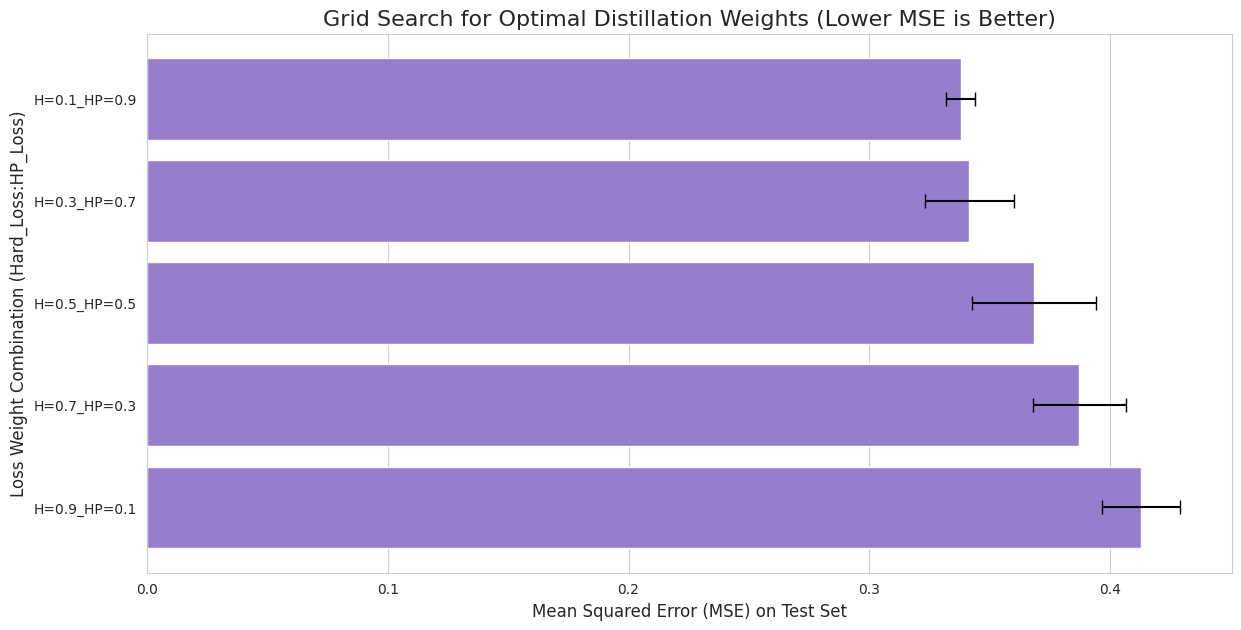

In [ ]:
import pandas as pd

# --- Configuration for Part 3 Grid Search ---
# We use the original student hyperparameters because we are training from scratch
LR_GRID_SEARCH = LR_STUDENT
EPOCHS_GRID_SEARCH = EPOCHS_STUDENT

# Define the grid of weights to search
weight_combinations = [
    {'hard': 0.1, 'hp': 0.9},
    {'hard': 0.3, 'hp': 0.7}, # The original weights from Part 2
    {'hard': 0.5, 'hp': 0.5},
    {'hard': 0.7, 'hp': 0.3},
    {'hard': 0.9, 'hp': 0.1},
]

# Store results for each weight combination
grid_search_results = {f"H={w['hard']}_HP={w['hp']}": {'mse': [], 'r2': []} for w in weight_combinations}

# A flexible distillation trainer that accepts weights
def train_student_distilled(student_model, teacher_model, loader, optimizer, epochs, pbar, weights):
    """Distillation training with a flexible weights dictionary."""
    student_model.train()
    teacher_model.eval()
    for epoch in range(epochs):
        for X_batch, y_batch_true in loader:
            optimizer.zero_grad()
            y_pred_student = student_model(X_batch)
            with torch.no_grad():
                y_pred_teacher = teacher_model(X_batch)

            loss_hard = criterion(y_pred_student, y_batch_true)
            loss_soft_hp = criterion(y_pred_student, y_pred_teacher)

            combined_loss = weights['hard'] * loss_hard + weights['hp'] * loss_soft_hp
            combined_loss.backward()
            optimizer.step()
        pbar.update(1)
    return student_model

# --- Main Grid Search Loop ---
# This will take longer as it's N_RUNS * len(weight_combinations) full training sessions
with tqdm(total=N_RUNS * len(weight_combinations), desc="Grid Search Full Training") as pbar:
    for i in range(N_RUNS):
        # Load the expert teacher from this specific run in Part 2
        expert_teacher = ExpertTeacherNet().to(device)
        expert_teacher.load_state_dict(part2_model_states[i]['expert_teacher'])

        # The initial student state for this run
        student_initial_state = initial_student_states[i]

        for weights in weight_combinations:
            pbar.set_description(f"Run {i+1}, Weights H={weights['hard']}:HP={weights['hp']}")

            # Re-initialize student and optimizer for each grid point
            student_to_train = StudentNet().to(device)
            student_to_train.load_state_dict(student_initial_state) # Start from scratch
            optimizer = optim.Adam(student_to_train.parameters(), lr=LR_GRID_SEARCH)

            # Train the model from scratch
            with tqdm(total=EPOCHS_GRID_SEARCH, desc=f"Training H={weights['hard']}", leave=False) as epoch_pbar:
                student_to_train = train_student_distilled(
                    student_to_train, expert_teacher, train_loader, optimizer,
                    EPOCHS_GRID_SEARCH, epoch_pbar, weights
                )

            # Evaluate and store the results
            _, mse, r2 = evaluate_model(student_to_train, X_test_tensor, y_test_tensor)
            key = f"H={weights['hard']}_HP={weights['hp']}"
            grid_search_results[key]['mse'].append(mse)
            grid_search_results[key]['r2'].append(r2)

            pbar.update(1)

# --- Process and Display Grid Search Results ---
results_df_data = []
for name, data in grid_search_results.items():
    results_df_data.append({
        'Weights': name,
        'Mean MSE': np.mean(data['mse']),
        'Std Dev MSE': np.std(data['mse']),
        'Mean R2': np.mean(data['r2'])
    })

results_df = pd.DataFrame(results_df_data).sort_values(by='Mean MSE').reset_index(drop=True)

# Identify the best result from the grid search
best_grid_search_result = results_df.iloc[0]
best_grid_search_name = "Student (Distilled, Optimal HP Weights)"
best_grid_search_stats = grid_search_results[best_grid_search_result['Weights']]


print(f"\n{'='*20} RESULTS FOR PART 3: GRID SEARCH (over {N_RUNS} runs) {'='*20}")
print(results_df.to_string())
print(f"\nBest performance achieved with weights: {best_grid_search_result['Weights']}")

# --- Visualize the Grid Search Results ---
plt.figure(figsize=(14, 7))
sns.barplot(x='Mean MSE', y='Weights', data=results_df, orient='h', color='mediumpurple')
plt.errorbar(x=results_df['Mean MSE'], y=results_df.index, xerr=results_df['Std Dev MSE'], fmt='none', c='black', capsize=5)
plt.title('Grid Search for Optimal Distillation Weights (Lower MSE is Better)', fontsize=16)
plt.xlabel('Mean Squared Error (MSE) on Test Set', fontsize=12)
plt.ylabel('Loss Weight Combination (Hard_Loss:HP_Loss)', fontsize=12)
plt.grid(True, axis='x')
plt.show()

### Comment
You can clearly see that the more weight we give to the teacher's predictions, the better the student performs. This is a clear indication that the teacher's knowledge is valuable and that the student benefits significantly from mimicking it.

Of course, this is highly dependent on the task at hand: this notebook is a toy example and as often happens in machine learning, the results may not generalise to other tasks. However, the principles of knowledge distillation and the importance of teacher quality remain valid across various domains.

# 5. Advanced Distillation with Gradient Regularization (L_GR)

### Deeper Knowledge Transfer
So far, our distillation has focused on mimicking the teacher's final predictions (the *what*). This is known as response-based knowledge distillation. However, a teacher model also contains implicit knowledge about the *sensitivity* of its predictions to changes in the input data. This is captured by the gradient of the loss function with respect to the inputs.

**Gradient Regularization (L_GR)** is an advanced feature-based distillation technique where the student is trained to not only match the teacher's outputs but also to mimic the teacher's loss gradients. In essence, we want the student's loss landscape to locally resemble the teacher's.

Let’s see whether by transferring this deeper knowledge of the loss landscape, the student can learn a more robust and accurate function. The combined loss function now includes a third term:

$$
L = \lambda_1 \|y - y^{(s)}\|^2 + \lambda_2 \|y^{(t)} - y^{(s)}\|^2 + \lambda_3 \|\nabla_x L^{(t)} - \nabla_x L^{(s)}\|^2
$$

In [ ]:
def train_student_gradient_distillation(student_model, teacher_model, loader, optimizer, epochs, pbar, weights):
    """Distillation training including Gradient Regularization (L_GR)."""
    student_model.train()
    teacher_model.eval()

    for epoch in range(epochs):
        for X_batch, y_batch_true in loader:
            # We need to track gradients with respect to the input for this batch
            X_batch.requires_grad_(True)
            optimizer.zero_grad()

            # --- Get Teacher Gradients (we don't need to backprop into the teacher) ---
            with torch.no_grad():
                y_pred_teacher = teacher_model(X_batch)
                loss_t = criterion(y_pred_teacher, y_batch_true)
            # We need to calculate teacher grads WITH a computation graph to backprop through them for the STUDENT
            # but we only need the grad values, so this is a bit tricky.
            # A simpler, common approach is to calculate grads and then detach them.
            teacher_loss_for_grad = criterion(teacher_model(X_batch), y_batch_true)
            grad_t = torch.autograd.grad(teacher_loss_for_grad, X_batch, grad_outputs=torch.ones_like(teacher_loss_for_grad), retain_graph=False)[0].detach()

            # --- Get Student Gradients ---
            y_pred_student = student_model(X_batch)
            loss_s_for_grad = criterion(y_pred_student, y_batch_true)
            # create_graph=True is crucial because we need to backpropagate through the gradient calculation itself
            grad_s = torch.autograd.grad(loss_s_for_grad, X_batch, grad_outputs=torch.ones_like(loss_s_for_grad), create_graph=True)[0]

            # --- Calculate all three loss components ---
            # Standard hard loss (using the student prediction we already have)
            loss_hard = criterion(y_pred_student, y_batch_true)
            # Standard soft HP loss (using the detached teacher prediction)
            loss_soft_hp = criterion(y_pred_student, y_pred_teacher)
            # New Gradient Regularization loss
            loss_gr = criterion(grad_s, grad_t)

            combined_loss = (weights['hard'] * loss_hard +
                             weights['hp'] * loss_soft_hp +
                             weights['gr'] * loss_gr)

            combined_loss.backward()
            optimizer.step()

            # Important: turn off requires_grad for the next batch to avoid issues
            X_batch.requires_grad_(False)

        pbar.update(1)

    return student_model

Training Student with L_GR:   0%|          | 0/5 [00:00<?, ?it/s]

Run 1 L_GR:   0%|          | 0/600 [00:00<?, ?it/s]

Run 2 L_GR:   0%|          | 0/600 [00:00<?, ?it/s]

Run 3 L_GR:   0%|          | 0/600 [00:00<?, ?it/s]

Run 4 L_GR:   0%|          | 0/600 [00:00<?, ?it/s]

Run 5 L_GR:   0%|          | 0/600 [00:00<?, ?it/s]


========================= FINAL COMPREHENSIVE RESULTS (over 5 runs) =========================
                                      Model  Mean MSE  Std Dev MSE
0            Expert Teacher (for reference)  0.255374     0.008914
1   Student (Distilled, Optimal HP Weights)  0.337854     0.006115
2             Student (Distilled with L_GR)  0.341102     0.015041
3  Student (Distilled from Expert, 0.3/0.7)  0.350947     0.011420
4                         Student (Scratch)  0.453893     0.019263


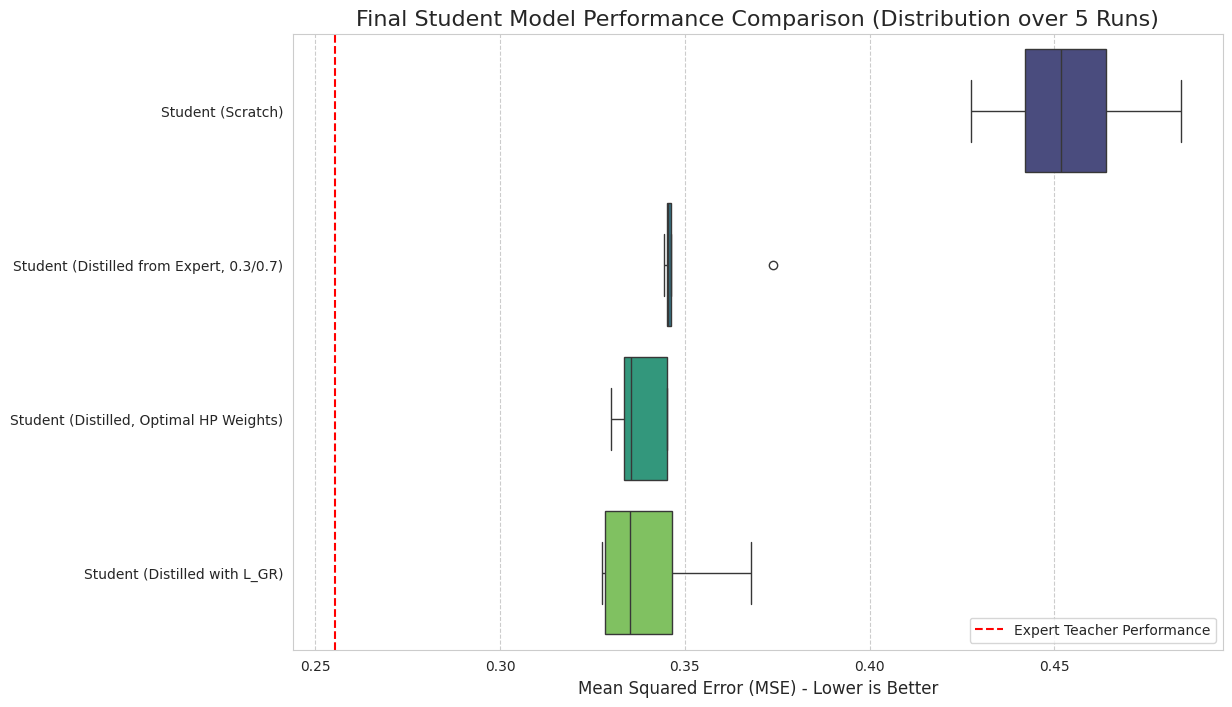


==================== Statistical Test: L_GR vs. Best L_HP ====================
Comparing MSEs of 'Student (Distilled with L_GR)' vs 'Student (Distilled, Optimal HP Weights)'
Mean MSE (L_GR): 0.3411
Mean MSE (Best L_HP): 0.3379

Paired t-test p-value: 0.5628
There is NO statistically significant difference between the two models.


In [ ]:
# --- Configuration for Part 4 ---
# We'll use a reasonable guess for the three-way loss balance.
# A full 3D grid search would be too slow. We give less weight to the hard loss
# and split the "teacher knowledge" between predictions (HP) and gradients (GR).
GRADIENT_WEIGHTS = {'hard': 0.2, 'hp': 0.5, 'gr': 0.3}
LR_GRADIENT = LR_STUDENT
EPOCHS_GRADIENT = EPOCHS_STUDENT

# --- Run the L_GR Experiment ---
student_l_gr_results = {'mse': [], 'r2': []}
with tqdm(total=N_RUNS, desc="Training Student with L_GR") as pbar:
    for i in range(N_RUNS):
        # Load the expert teacher from this specific run
        expert_teacher = ExpertTeacherNet().to(device)
        expert_teacher.load_state_dict(part2_model_states[i]['expert_teacher'])

        # Initialize student from scratch
        student_l_gr = StudentNet().to(device)
        student_l_gr.load_state_dict(initial_student_states[i])
        optimizer = optim.Adam(student_l_gr.parameters(), lr=LR_GRADIENT)

        # Train with the new advanced distillation method
        with tqdm(total=EPOCHS_GRADIENT, desc=f"Run {i+1} L_GR", leave=False) as epoch_pbar:
            student_l_gr = train_student_gradient_distillation(
                student_l_gr, expert_teacher, train_loader, optimizer,
                EPOCHS_GRADIENT, epoch_pbar, GRADIENT_WEIGHTS
            )

        # Evaluate and store results
        _, mse, r2 = evaluate_model(student_l_gr, X_test_tensor, y_test_tensor)
        student_l_gr_results['mse'].append(mse)
        student_l_gr_results['r2'].append(r2)
        pbar.update(1)

# --- Final Comprehensive Results Aggregation ---
# We retrieve the best model from the Part 3 grid search to compare against
final_comprehensive_results = {
    "Student (Scratch)": part1_results["Student (Scratch)"],
    "Student (Distilled from Expert, 0.3/0.7)": student_distilled_expert_results,
    best_grid_search_name: best_grid_search_stats,
    "Student (Distilled with L_GR)": student_l_gr_results,
    "Expert Teacher (for reference)": expert_teacher_results
}

# --- Final Table ---
final_df_data = []
for name, data in final_comprehensive_results.items():
    final_df_data.append({
        'Model': name,
        'Mean MSE': np.mean(data['mse']),
        'Std Dev MSE': np.std(data['mse']),
    })
final_df = pd.DataFrame(final_df_data).sort_values(by='Mean MSE').reset_index(drop=True)

print(f"\n{'='*25} FINAL COMPREHENSIVE RESULTS (over {N_RUNS} runs) {'='*25}")
print(final_df.to_string())

# --- Final Visualization (Box Plot is best for showing distribution) ---
# Create a long-form DataFrame suitable for seaborn plotting
plot_data = []
for name, data in final_comprehensive_results.items():
    # Only plot student models for a cleaner visualization
    if "Teacher" not in name:
        for mse_val in data['mse']:
            plot_data.append({'Model': name, 'MSE': mse_val})
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))
sns.boxplot(data=plot_df, x='MSE', y='Model', hue='Model', palette='viridis', legend=False)
plt.axvline(x=final_df[final_df['Model'] == 'Expert Teacher (for reference)']['Mean MSE'].iloc[0],
            color='r', linestyle='--', label='Expert Teacher Performance')
plt.title('Final Student Model Performance Comparison (Distribution over 5 Runs)', fontsize=16)
plt.xlabel('Mean Squared Error (MSE) - Lower is Better', fontsize=12)
plt.ylabel('')
plt.legend()
plt.grid(True, axis='x', linestyle='--')
plt.show()


# --- Final Statistical Test ---
# We compare the best-performing student (from the grid search) against the L_GR student.
from scipy.stats import ttest_rel
best_hp_mse = final_comprehensive_results[best_grid_search_name]['mse']
l_gr_mse = final_comprehensive_results["Student (Distilled with L_GR)"]['mse']
# We use a two-sided test now because we don't have a strong prior hypothesis that one is better.
t_stat, p_val = ttest_rel(l_gr_mse, best_hp_mse)

print(f"\n{'='*20} Statistical Test: L_GR vs. Best L_HP {'='*20}")
print(f"Comparing MSEs of 'Student (Distilled with L_GR)' vs '{best_grid_search_name}'")
print(f"Mean MSE (L_GR): {np.mean(l_gr_mse):.4f}")
print(f"Mean MSE (Best L_HP): {np.mean(best_hp_mse):.4f}")
difference = np.mean(l_gr_mse) - np.mean(best_hp_mse)

print(f"\nPaired t-test p-value: {p_val:.4f}")
if p_val < 0.05:
    if difference < 0:
        print("The L_GR model is statistically significantly BETTER.")
    else:
        print("The L_GR model is statistically significantly WORSE.")
else:
    print("There is NO statistically significant difference between the two models.")
print("="*68)

### Analysis: The Impact of Gradient Regularisation

The results from this last experiment provide a crucial insight into the complexities of advanced knowledge distillation techniques. Incorporating `L_GR` didn't yield improvements.


There are several common reasons why a more complex distillation method like Gradient Regularization might not yield superior results, especially in a toy example or without extensive tuning:

1.  **Hyperparameter Sensitivity:** The `L_GR` loss introduces a third weighting hyperparameter ($\lambda_3$). Optimising a three-way balance (`hard_loss`, `hp_loss`, `gr_loss`) is significantly more complex than optimizing two. Our chosen weights for `L_GR` (`hard`: 0.2, `hp`: 0.5, `gr`: 0.3) were just a guess, and it's highly probable they were not optimal for this specific dataset and model architecture. A comprehensive 3D grid search or more advanced hyperparameter optimisation might be necessary to unlock its full potential.

2.  **Gradient Noise and Specificity:** While gradients provide rich information, they can also be noisy or capture very specific local features of the teacher's internal representation. Forcing the student to mimic these exact gradients might lead it to learn noise or nuances that do not generalise well, rather than robust, high-level knowledge. In some cases, distilling only the final predictions (`L_HP`) is sufficient because the teacher's output already encapsulates the most relevant "dark knowledge."

3.  **Redundancy of Information:** For certain problems, the information conveyed by the teacher's raw predictions (`y^{(t)}`) might already be comprehensive enough that additional gradient information offers diminishing returns or even becomes counterproductive. The student may not need this extra signal to efficiently learn the underlying function.

### Conclusion from the Experiment

This experiment demonstrates that while advanced distillation techniques like `L_GR` exist and can be powerful, they are not a guaranteed improvement. The most effective strategy in this particular setup was to:

1.  **Train a highly capable Teacher model.**
2.  **Perform basic response-based distillation (`L_HP`) from this expert teacher.**
3.  **Conduct a thorough grid search to find the optimal weighting between the ground truth (`hard_loss`) and the teacher's predictions (`hp_loss`).**

The robustness of `L_HP` combined with careful hyperparameter tuning proved to be more effective and practical than attempting to incorporate more complex gradient-based knowledge transfer without extensive optimisation. This highlights the importance of empirical validation and hyperparameter tuning in real-world knowledge distillation applications.

**Knowledge Distillation is an art: you need to experiment and find the right balance for your specific task. Each data set and model architecture may require different approaches and tuning strategies to achieve optimal results. While some techniques may seem promising from a theoretical perspective, their practical effectiveness can vary widely based on the specific context and implementation details.**